In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis
from ramandecompy import dataimport
from scipy import interpolate

In [2]:
def clean_spectra(df,compound):
    """
    Function that cleans the data of any duplicate x-values that will cause
    errors for interpolation.
    Args:
        compound (str): shoyu_data_dict key for the desired compound
    Returns:
        comp_data_clean (list): list of tuples containing all the non-repeated
                                x and y values
    """
    # handling errors in inputs
    if not isinstance(compound, str):
        raise TypeError("Passed value of `compound` is not a dictionary! Instead, it is: "
                        + str(type(compound)))
    # extract data from dictionary
    x_comp = df['Wavelength']
    y_comp = df[compound]
    # zip x and y values
    comp_data = list(zip(x_comp, y_comp))
    #clean comp1
    comp_data_clean = []
    for i in range(1, len(comp_data)-1):
        if comp_data[i][0] == comp_data[i-1][0]:
            pass
        else:
            comp_data_clean.append(comp_data[i])
    return comp_data_clean


def interpolate_spectra(comp_data_clean):
    """
    Function that produces interpolated values for the spectra at integer values
    across the range of the data.
    Args:
        comp_data_clean (list): list of tuples containing all the non-repeated
                                x and y values
    Returns:
        comp_data_int (list): list of interpolated values for the spectra at integer
                              values across the range of the input data
    """
    # handling errors in inputs
    if not isinstance(comp_data_clean, list):
        raise TypeError('Passed value of `comp_data_clean` is not a list! Instead, it is: '
                        + str(type(comp_data_clean)))
    for i, _ in enumerate(comp_data_clean):
        if not isinstance(comp_data_clean[i], tuple):
            raise TypeError('Component of the passed value is not a tuple! Instead, it is: '
                            + str(type(comp_data_clean[i])))
    # unzip data
    x_comp, y_comp = zip(*comp_data_clean)
    # interpolate data
    comp_int = interpolate.interp1d(x_comp, y_comp, kind='linear')
    # 'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
#     'previous', 'next',
# cubic and quadratic dont work
    # define ranges
    comp_range = np.arange(int(min(x_comp))+1, int(max(x_comp)), 1)
    # run interpolations
    y_comp_interp = comp_int(comp_range)
    # zip interpolated values
    comp_data_int = list(zip(comp_range, y_comp_interp))
    return comp_data_int
def sum_spectra(comp1_data_int, comp2_data_int):
    """
    Function that adds the interpolated values for two spectra together.
    Args:
        comp1_data_int (list): list of tuples containing all the non-repeated
                               x and y values for compound 1
        comp2_data_int (list): list of tuples containing all the non-repeated
                               x and y values for compound 2
    Returns:
        x_combined (list): list of summed x-values across the range of
                           of the two compounds
        y_combined (list): list of summed y-values across the range of
                           of the two compounds
    """
    # handling errors in inputs
    if not isinstance(comp1_data_int, list):
        raise TypeError('Passed value of `comp1_data_int` is not a list! Instead, it is: '
                        + str(type(comp1_data_int)))
    # add the two spectra
    combined = sorted(comp1_data_int + comp2_data_int)
    # add by like
    same_x = {x:0 for x, _ in combined}
    for name, num in combined:
        same_x[name] += num
    sum_combined = list(map(tuple, same_x.items()))
    # unzip
    x_combined, y_combined = zip(*sum_combined)
    # set as arrays
    x_combined = np.asarray(x_combined)
    y_combined = np.asarray(y_combined)
    return x_combined, y_combined
def combine_spectra(df,compound_1, compound_2, plot=False):
    """
    Wrapping function that sums two compounds from shoyu_data_dict.p
    together. There is an optional plotting function embedded.
    Args:
         compound_1 (str): dictionary key for the compound in shoyu_data_dict.p
         compound_2 (str): dictionary key for the compound in shoyu_data_dict.p
         plot (boolean): (Optional) This argument is used to dictate whether or not you
                         would like to output a plot which shows the combined spectra,
                         as well as the two original spectra, overlaid on the same plot.
                         Defaults to False.
     Returns:
         x_combined (numpy array): The x-values of the new spectra that contains the
                                   combined values of the two spectra that were input.
         y_combined (numpy array): The y-values of the new spectra that contains the
                                   combined values of the two spectra that were input.
    """
    # handling errors in inputs
#     if not isinstance(compound_1, str):
#         raise TypeError("Passed value of `compound_1` is not a dictionary! Instead, it is: "
#                         + str(type(compound_1)))
#     if not isinstance(compound_2,str):
#         raise TypeError("Passed value of `compound_2` is not a dictionary! Instead, it is: "
#                         + str(type(compound_1)))
    data1 = clean_spectra(df,compound_1)
    data2 = clean_spectra(df,compound_2)
    maxwavenumber = len(df['Wavelength'])
    comp1_data_int = interpolate_spectra(data1)
    comp2_data_int = interpolate_spectra(data2)
    x_combined, y_combined = sum_spectra(comp1_data_int, comp2_data_int)
    y_combined = pd.DataFrame(y_combined)
    column = str(compound_1)+'+'+str(compound_2)
    print(column)
    if plot:
        # plot original data and combined plot
        plt.figure(figsize=(15, 5))
        plt.plot([i[0] for i in data1], [i[1] for i in data1], 'b--', label=df[compound_1])
        plt.plot([i[0] for i in data2], [i[1] for i in data2], 'g--', label=df[compound_2])
        plt.plot(x_combined, y_combined, 'r', label='Combination', linewidth=2, alpha=0.7)
        plt.legend()
        plt.xlabel('cm$^{-1}$', fontsize=14)
        plt.ylabel('Absoprtion', fontsize=14)
    return y_combined,column

In [3]:
df = pd.read_excel('../ramandecompy/tests/test_files/CalibrationSpectraCombined.xlsx')

In [4]:
df = df.fillna(0)

In [5]:
df

Wavelength   Hydrogen  Sapphire  CarbonDioxide  CarbonMonoxide  \
0     250.340000   0.989673  0.133289      -3.627004        0.000056   
1     253.348869   1.041293  0.137142      -0.359460        0.000056   
2     256.357738   1.097466  0.141168       0.000000        0.000056   
3     259.366607   1.158758  0.145375     -17.592200        0.000056   
4     262.375475   1.225830  0.149777      -8.518800        0.000056   
5     265.384344   1.299453  0.154363      -1.177166        0.000057   
6     268.393213   1.380532  0.159189      -6.208544        0.000057   
7     271.402082   1.470133  0.164249     -14.850600        0.000057   
8     274.410951   1.569526  0.169534      -0.984380        0.000057   
9     277.419820   1.680221  0.175109      -4.867428        0.000057   
10    280.428689   1.804038  0.180941      -6.469380        0.000058   
11    283.437558   1.943177  0.187104      -0.913680        0.000058   
12    286.446426   2.100323  0.193565       0.026820        0.000058   
13    289.455295   2.278775  0.200373      -4.636100        0.000058   
14    292.464164   2.482629  0.207589      -2.165304        0.000058   
15    295.473033   2.717014  0.215176      -3.709120        0.000058   
16    298.481902   2.988425  0.223198      -2.489558        0.000059   
17    301.490771   3.305184  0.231689       1.611680        0.000059   
18    304.499640   3.678086  0.240687      -4.466100        0.000059   
19    307.508509   4.121339  0.250236       2.137480        0.000059   
20    310.517377   4.653945  0.260383      -1.718412        0.000059   
21    313.526246   5.301764  0.271181      -6.508794        0.000060   
22    316.535115   6.100710  0.282688       5.901780        0.000060   
23    319.543984   7.101802  0.294914       2.730240        0.000060   
24    322.552853   8.379439  0.308043       0.822644        0.000060   
25    325.561722  10.045430  0.322040       6.871320        0.000060   
26    328.570591  12.273837  0.337126       4.618260        0.000061   
27    331.579459  15.347152  0.353348       5.991242        0.000061   
28    334.588328  19.747258  0.370748      10.388440        0.000061   
29    337.597197  26.347554  0.389535       0.901300        0.000061   
...          ...        ...       ...            ...             ...   
1911    0.000000   0.000000  0.000431       6.678224        0.000000   
1912    0.000000   0.000000  0.000431       2.197764        0.000000   
1913    0.000000   0.000000  0.000431       6.652140        0.000000   
1914    0.000000   0.000000  0.000430       4.732600        0.000000   
1915    0.000000   0.000000  0.000430       1.713044        0.000000   
1916    0.000000   0.000000  0.000430       0.676090        0.000000   
1917    0.000000   0.000000  0.000429       4.579646        0.000000   
1918    0.000000   0.000000  0.000429       0.839448        0.000000   
1919    0.000000   0.000000  0.000429      12.707600        0.000000   
1920    0.000000   0.000000  0.000429       5.443752        0.000000   
1921    0.000000   0.000000  0.000428       7.401160        0.000000   
1922    0.000000   0.000000  0.000428       5.230240        0.000000   
1923    0.000000   0.000000  0.000428       0.812522        0.000000   
1924    0.000000   0.000000  0.000428       3.639900        0.000000   
1925    0.000000   0.000000  0.000427       0.657940        0.000000   
1926    0.000000   0.000000  0.000427      10.736300        0.000000   
1927    0.000000   0.000000  0.000427       6.754020        0.000000   
1928    0.000000   0.000000  0.000426       1.230720        0.000000   
1929    0.000000   0.000000  0.000426       4.115960        0.000000   
1930    0.000000   0.000000  0.000426       3.730517        0.000000   
1931    0.000000   0.000000  0.000426       2.735978        0.000000   
1932    0.000000   0.000000  0.000425       1.089952        0.000000   
1933    0.000000   0.000000  0.000425       0.723678        0.000000   
1934    0.000000   0.000000  0.000425       0.

In [6]:
len(df['Wavelength'])

1941

Formic Acid+Hydrogen


(             0
 0     0.351241
 1     0.355831
 2     0.360421
 3     0.365011
 4     0.369601
 5     0.374190
 6     0.378780
 7     0.383370
 8     0.387960
 9     0.392550
 10    0.397140
 11    0.401730
 12    0.406320
 13    0.410910
 14    0.415500
 15    0.420089
 16    0.424679
 17    0.429269
 18    0.433859
 19    0.438449
 20    0.443039
 21    0.447629
 22    0.452219
 23    0.456809
 24    0.461399
 25    0.465988
 26    0.470578
 27    0.475168
 28    0.479758
 29    0.484348
 ...        ...
 3225  0.363148
 3226  0.362772
 3227  0.362395
 3228  0.362017
 3229  0.361663
 3230  0.361312
 3231  0.360961
 3232  0.360612
 3233  0.360263
 3234  0.359915
 3235  0.359569
 3236  0.359223
 3237  0.358878
 3238  0.358515
 3239  0.358150
 3240  0.357785
 3241  0.357441
 3242  0.357101
 3243  0.356761
 3244  0.356424
 3245  0.356086
 3246  0.355749
 3247  0.355414
 3248  0.355080
 3249  0.354746
 3250  0.354413
 3251  0.354082
 3252  0.353750
 3253  0.353403
 3254  0.353052
 
 [3255

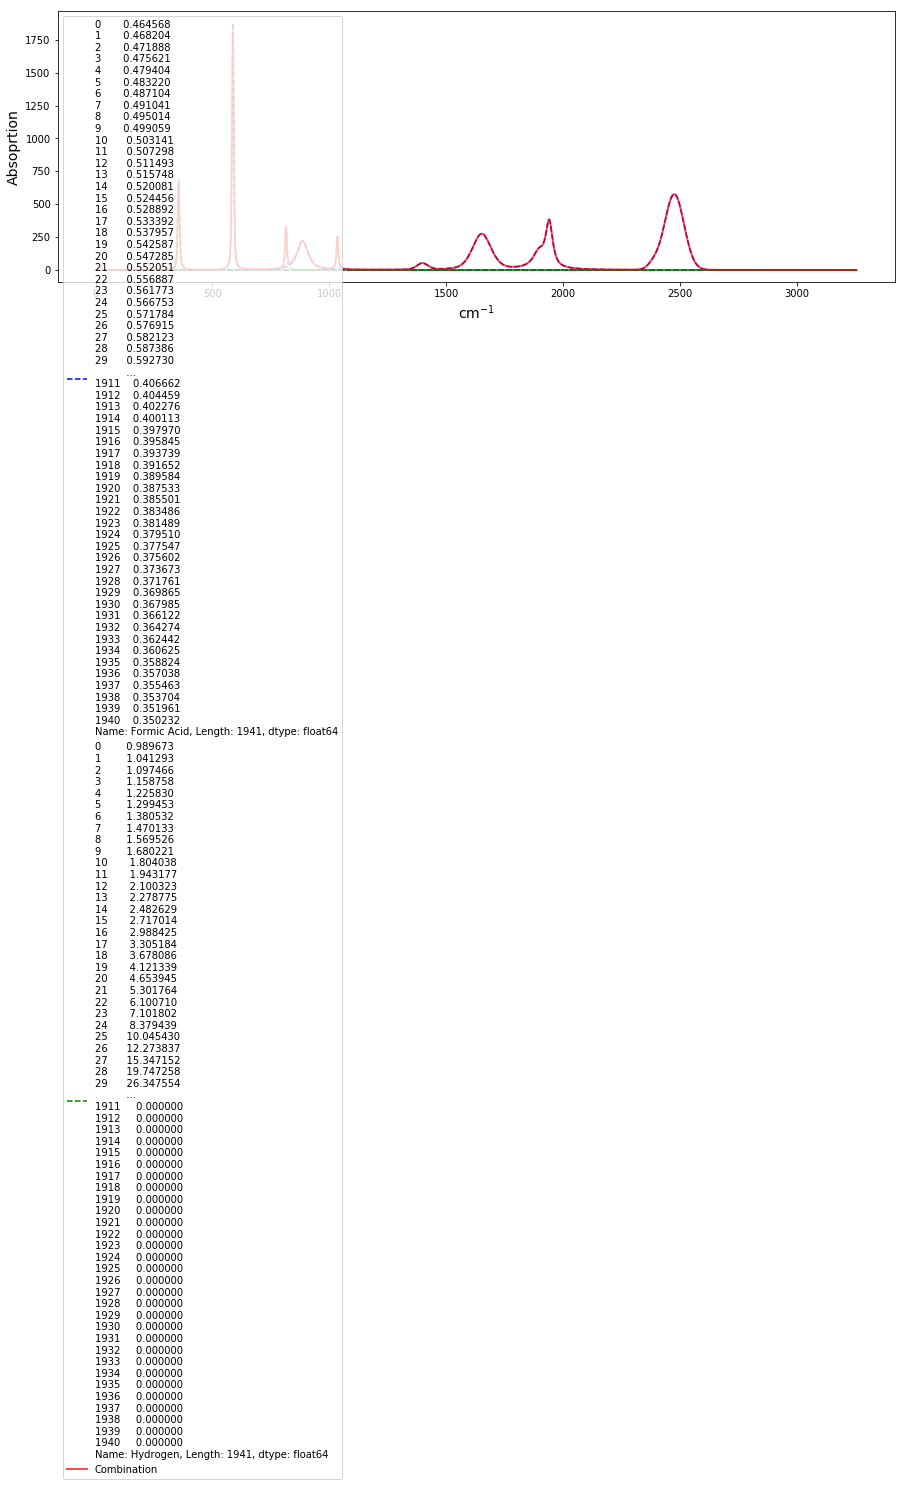

In [7]:
combine_spectra(df, 'Formic Acid','Hydrogen', plot=True)

In [8]:
combine_spectra(df, 'Sapphire','Formic Acid', plot=False)[1]

Sapphire+Formic Acid


'Sapphire+Formic Acid'

In [9]:
key_list = ['Hydrogen','Sapphire','CarbonDioxide','CarbonMonoxide','Formic Acid','Water','Acetaldehyde','Ethane','Methane','Propane']
frames = [ combine_spectra(df, key_x, key_y, plot=False)[0] for key_x in key_list for key_y in key_list ]
columns = [ combine_spectra(df, key_x, key_y, plot=False)[1] for key_x in key_list for key_y in key_list ]

Hydrogen+Hydrogen
Hydrogen+Sapphire
Hydrogen+CarbonDioxide
Hydrogen+CarbonMonoxide
Hydrogen+Formic Acid
Hydrogen+Water
Hydrogen+Acetaldehyde
Hydrogen+Ethane
Hydrogen+Methane
Hydrogen+Propane
Sapphire+Hydrogen
Sapphire+Sapphire
Sapphire+CarbonDioxide
Sapphire+CarbonMonoxide
Sapphire+Formic Acid
Sapphire+Water
Sapphire+Acetaldehyde
Sapphire+Ethane
Sapphire+Methane
Sapphire+Propane
CarbonDioxide+Hydrogen
CarbonDioxide+Sapphire
CarbonDioxide+CarbonDioxide
CarbonDioxide+CarbonMonoxide
CarbonDioxide+Formic Acid
CarbonDioxide+Water
CarbonDioxide+Acetaldehyde
CarbonDioxide+Ethane
CarbonDioxide+Methane
CarbonDioxide+Propane
CarbonMonoxide+Hydrogen
CarbonMonoxide+Sapphire
CarbonMonoxide+CarbonDioxide
CarbonMonoxide+CarbonMonoxide
CarbonMonoxide+Formic Acid
CarbonMonoxide+Water
CarbonMonoxide+Acetaldehyde
CarbonMonoxide+Ethane
CarbonMonoxide+Methane
CarbonMonoxide+Propane
Formic Acid+Hydrogen
Formic Acid+Sapphire
Formic Acid+CarbonDioxide
Formic Acid+CarbonMonoxide
Formic Acid+Formic Acid
Formic 

In [10]:
frames

[             0
 0     0.008220
 1     0.016440
 2     0.024661
 3     0.032881
 4     0.041101
 5     0.049321
 6     0.057542
 7     0.065762
 8     0.073982
 9     0.082202
 10    0.090423
 11    0.098643
 12    0.106863
 13    0.115083
 14    0.123303
 15    0.131524
 16    0.139744
 17    0.147964
 18    0.156184
 19    0.164405
 20    0.172625
 21    0.180845
 22    0.189065
 23    0.197286
 24    0.205506
 25    0.213726
 26    0.221946
 27    0.230167
 28    0.238387
 29    0.246607
 ...        ...
 3225  0.010259
 3226  0.010251
 3227  0.010243
 3228  0.010235
 3229  0.010227
 3230  0.010219
 3231  0.010211
 3232  0.010203
 3233  0.010196
 3234  0.010188
 3235  0.010180
 3236  0.010172
 3237  0.010164
 3238  0.010156
 3239  0.010148
 3240  0.010140
 3241  0.010132
 3242  0.010125
 3243  0.010117
 3244  0.010109
 3245  0.010101
 3246  0.010093
 3247  0.010085
 3248  0.010078
 3249  0.010070
 3250  0.010062
 3251  0.010054
 3252  0.010046
 3253  0.010039
 3254  0.010031
 
 [3255

In [11]:
columns

['Hydrogen+Hydrogen',
 'Hydrogen+Sapphire',
 'Hydrogen+CarbonDioxide',
 'Hydrogen+CarbonMonoxide',
 'Hydrogen+Formic Acid',
 'Hydrogen+Water',
 'Hydrogen+Acetaldehyde',
 'Hydrogen+Ethane',
 'Hydrogen+Methane',
 'Hydrogen+Propane',
 'Sapphire+Hydrogen',
 'Sapphire+Sapphire',
 'Sapphire+CarbonDioxide',
 'Sapphire+CarbonMonoxide',
 'Sapphire+Formic Acid',
 'Sapphire+Water',
 'Sapphire+Acetaldehyde',
 'Sapphire+Ethane',
 'Sapphire+Methane',
 'Sapphire+Propane',
 'CarbonDioxide+Hydrogen',
 'CarbonDioxide+Sapphire',
 'CarbonDioxide+CarbonDioxide',
 'CarbonDioxide+CarbonMonoxide',
 'CarbonDioxide+Formic Acid',
 'CarbonDioxide+Water',
 'CarbonDioxide+Acetaldehyde',
 'CarbonDioxide+Ethane',
 'CarbonDioxide+Methane',
 'CarbonDioxide+Propane',
 'CarbonMonoxide+Hydrogen',
 'CarbonMonoxide+Sapphire',
 'CarbonMonoxide+CarbonDioxide',
 'CarbonMonoxide+CarbonMonoxide',
 'CarbonMonoxide+Formic Acid',
 'CarbonMonoxide+Water',
 'CarbonMonoxide+Acetaldehyde',
 'CarbonMonoxide+Ethane',
 'CarbonMonoxide+Met

In [12]:
from sklearn import preprocessing
# create the Labelencoder object
le = preprocessing.LabelEncoder()
known_compound_list = key_list
#convert the categorical columns into numeric
encoded_value = le.fit_transform(known_compound_list)
print(encoded_value)
print(known_compound_list)

[5 8 1 2 4 9 0 3 6 7]
['Hydrogen', 'Sapphire', 'CarbonDioxide', 'CarbonMonoxide', 'Formic Acid', 'Water', 'Acetaldehyde', 'Ethane', 'Methane', 'Propane']


In [13]:
result = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
          keys=columns, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [14]:
# result = result.join(df['Wavelength'])

In [15]:
result

Hydrogen+Hydrogen Hydrogen+Sapphire Hydrogen+CarbonDioxide  \
                     0                 0                      0   
0             0.008220          0.005799              -0.051940   
1             0.016440          0.010446              -0.049032   
2             0.024661          0.015093              -0.046125   
3             0.032881          0.019740              -0.043217   
4             0.041101          0.024386              -0.040309   
5             0.049321          0.029033              -0.037401   
6             0.057542          0.033680              -0.034494   
7             0.065762          0.038327              -0.031586   
8             0.073982          0.042974              -0.028678   
9             0.082202          0.047621              -0.025770   
10            0.090423          0.052268              -0.022862   
11            0.098643          0.056915              -0.019955   
12            0.106863          0.061562              -0.017047   
13            0.115083          0.066208              -0.014139   
14            0.123303          0.070855              -0.011231   
15            0.131524          0.075502              -0.008324   
16            0.139744          0.080149              -0.005416   
17            0.147964          0.084796              -0.002508   
18            0.156184          0.089443               0.000400   
19            0.164405          0.094090               0.003307   
20            0.172625          0.098737               0.006215   
21            0.180845          0.103384               0.009123   
22            0.189065          0.108030               0.012031   
23            0.197286          0.112677               0.014939   
24            0.205506          0.117324               0.017846   
25            0.213726          0.121971               0.020754   
26            0.221946          0.126618               0.023662   
27            0.230167          0.131265               0.026570   
28            0.238387          0.135912               0.029477   
29            0.246607          0.140559               0.032385   
...                ...               ...                    ...   
3225          0.010259          0.006305              -0.649833   
3226          0.010251          0.006300              -0.345375   
3227          0.010243          0.006295              -0.154525   
3228          0.010235          0.006290               0.036324   
3229          0.010227          0.006286               1.519095   
3230          0.010219          0.006281               3.178337   
3231          0.010211          0.006276               4.837580   
3232          0.010203          0.006272               4.163174   
3233          0.010196          0.006267               3.142990   
3234          0.010188          0.006262               2.122807   
3235          0.010180          0.006258               1.668582   
3236          0.010172          0.006253               1.304900   
3237          0.010164          0.006249               0.941219   
3238          0.010156          0.006244               0.163077   
3239          0.010148          0.006239              -0.686369   
3240          0.010140          0.006235              -1.535815   
3241          0.010132          0.006230              -2.183909   
3242          0.010125          0.006225              -2.794882   
3243          0.010117          0.006221              -3.405856   
3244          0.010109          0.006216              -3.287288   
3245          0.010101          0.006212              -3.025056   
3246          0.010093          0.006207              -2.762823   
3247          0.010085          0.006202              -1.173395   
3248          0.010078          0.006198               0.694432   
3249          0.010070          0.006193               2.562260   
3250          0.010062          0.006189               1.373068   
3251          0.010054          0.006184            

In [16]:
# result.to_excel("double.xlsx",sheet_name='Sheet_name_1')

In [17]:
df = pd.read_excel('../examples/double.xlsx')

In [18]:
df

Wavelength  Hydrogen+Hydrogen  Hydrogen+Sapphire  \
0              0           0.008220           0.005799   
1              1           0.016440           0.010446   
2              2           0.024661           0.015093   
3              3           0.032881           0.019740   
4              4           0.041101           0.024386   
5              5           0.049321           0.029033   
6              6           0.057542           0.033680   
7              7           0.065762           0.038327   
8              8           0.073982           0.042974   
9              9           0.082202           0.047621   
10            10           0.090423           0.052268   
11            11           0.098643           0.056915   
12            12           0.106863           0.061562   
13            13           0.115083           0.066208   
14            14           0.123303           0.070855   
15            15           0.131524           0.075502   
16            16           0.139744           0.080149   
17            17           0.147964           0.084796   
18            18           0.156184           0.089443   
19            19           0.164405           0.094090   
20            20           0.172625           0.098737   
21            21           0.180845           0.103384   
22            22           0.189065           0.108030   
23            23           0.197286           0.112677   
24            24           0.205506           0.117324   
25            25           0.213726           0.121971   
26            26           0.221946           0.126618   
27            27           0.230167           0.131265   
28            28           0.238387           0.135912   
29            29           0.246607           0.140559   
...          ...                ...                ...   
3225        3225           0.010259           0.006305   
3226        3226           0.010251           0.006300   
3227        3227           0.010243           0.006295   
3228        3228           0.010235           0.006290   
3229        3229           0.010227           0.006286   
3230        3230           0.010219           0.006281   
3231        3231           0.010211           0.006276   
3232        3232           0.010203           0.006272   
3233        3233           0.010196           0.006267   
3234        3234           0.010188           0.006262   
3235        3235           0.010180           0.006258   
3236        3236           0.010172           0.006253   
3237        3237           0.010164           0.006249   
3238        3238           0.010156           0.006244   
3239        3239           0.010148           0.006239   
3240        3240           0.010140           0.006235   
3241        3241           0.010132           0.006230   
3242        3242           0.010125           0.006225   
3243        3243           0.010117           0.006221   
3244        3244           0.010109           0.006216   
3245        3245           0.010101           0.006212   
3246        3246           0.010093           0.006207   
3247        3247           0.010085           0.006202   
3248        3248           0.010078           0.006198   
3249        3249           0.010070           0.006193   
3250        3250           0.010062           0.006189   
3251        3251           0.010054           0.006184   
3252        3252           0.010046           0.006180   
3253        3253           0.010039           0.006175   
3254        3254           0.010031           0.006170   

      Hydrogen+CarbonDioxide  Hydrogen+CarbonMonoxide  Hydrogen+Formic Acid  \
0                  -0.051940                 0.004110              0.351241   
1                  -0.049032                 0.008221              0.355831   
2                  -0.046125                 0.012331              0.360421   
3                  -0.043217                 0.016441              0.365011   
4             

Hydrogen+Hydrogen+Hydrogen+Formic Acid


(             0
 0     0.385081
 1     0.397892
 2     0.410702
 3     0.423512
 4     0.436322
 5     0.449132
 6     0.461942
 7     0.474752
 8     0.487562
 9     0.500373
 10    0.513183
 11    0.525993
 12    0.538803
 13    0.551613
 14    0.564423
 15    0.577233
 16    0.590044
 17    0.602854
 18    0.615664
 19    0.628474
 20    0.641284
 21    0.654094
 22    0.666904
 23    0.679715
 24    0.692525
 25    0.705335
 26    0.718145
 27    0.730955
 28    0.743765
 29    0.756575
 ...        ...
 3221  0.374137
 3222  0.373772
 3223  0.373407
 3224  0.373024
 3225  0.372638
 3226  0.372253
 3227  0.371890
 3228  0.371531
 3229  0.371172
 3230  0.370815
 3231  0.370459
 3232  0.370103
 3233  0.369749
 3234  0.369395
 3235  0.369042
 3236  0.368671
 3237  0.368298
 3238  0.367925
 3239  0.367573
 3240  0.367226
 3241  0.366878
 3242  0.366532
 3243  0.366187
 3244  0.365843
 3245  0.365500
 3246  0.365158
 3247  0.364815
 3248  0.364475
 3249  0.364136
 3250  0.363797
 
 [3251

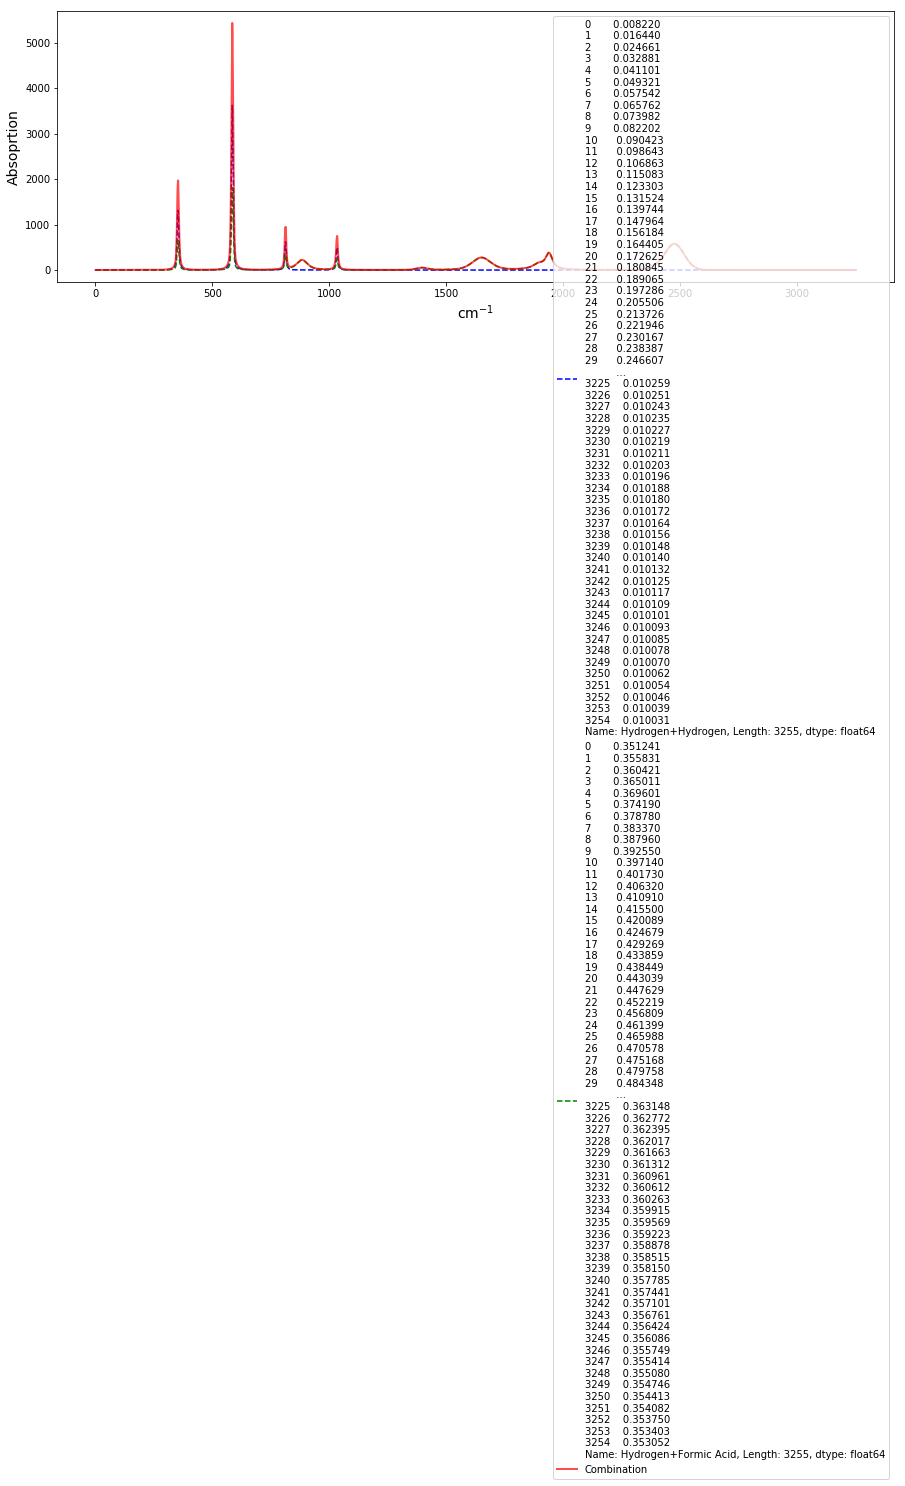

In [19]:
combine_spectra(df, 'Hydrogen+Hydrogen','Hydrogen+Formic Acid', plot=True)

In [ ]:
key_list = columns
frames = [ combine_spectra(df, key_x, key_y, plot=False)[0] for key_x in key_list for key_y in key_list ]
columns = [ combine_spectra(df, key_x, key_y, plot=False)[1] for key_x in key_list for key_y in key_list ]


In [ ]:
result = pd.concat(frames,axis=1, join='outer', join_axes=None, ignore_index=False,
          keys=columns, levels=None, names=None, verify_integrity=False,
          copy=True,sort=True)

In [ ]:
result

In [ ]:
columns

In [ ]:
# result.to_excel("triple.xlsx",sheet_name='Sheet_name_1')